In [1]:
import geopandas as gpd
import geoplot as gplt
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.legend import Legend
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar

import mapclassify as mc
import math

from handlers import TextLegendHandler
from helper_scripts import utils

# set up a handler for text legends
Legend.update_default_handler_map({str: TextLegendHandler.TextHandler()})

# disable settingwithcopywarning, a false positive in our case
pd.options.mode.chained_assignment = None  # default='warn'

# update default font
plt.rcParams["font.family"] = "Frutiger Light Condensed"

### helper functions

In [16]:
def preprocess_data(data: pd.DataFrame, post: str, party: str) -> pd.DataFrame:
    """
    Preprocesses the data and aggregates it by party and wards
    for the specific post and the specific party

    Args:
        post (str): the post in contention
        party (str): the political party in contention
    """
    preprocessed_data = data[(data["contested_post"] == post)]
    preprocessed_data = preprocessed_data[["party", "palika", "ward", "votes"]]

    preprocessed_data = (
        preprocessed_data.groupby(["party", "palika", "ward"]).sum().reset_index()
    )

    preprocessed_data["% of ward votes"] = (
        preprocessed_data["votes"]
        / preprocessed_data.groupby(["palika", "ward"])["votes"].transform("sum")
        * 100
    )

    preprocessed_data = preprocessed_data[preprocessed_data["party"] == party]

    return preprocessed_data


def clean_data(
    raw_data: pd.DataFrame, constituency_map: pd.DataFrame, district: str
) -> gpd.GeoDataFrame:
    """
    Selects the required district and cleans the resulting dataframe

    Will only return the data for regions that have the correct constituencies populated
    (i.e. whose provincial constituency value is not 0)

    Args:
        raw_data (pd.DataFrame): The raw dataframe
        TODO constituency_map (pd.DataFrame): A dataframe containing the constituency map for each palika-ward combination
                                                (only used in cases where the constituency map in the raw_data is wrong - remove once all this has been populated)
        district (str): the district for which to generate analytics

    Returns:
        pd.DataFrame: A geodatafarme of the cleaned data
    """
    elec_data_district = raw_data.query(
        f'district.str.contains("{district.lower()}")', engine="python"
    )

    constituency_clean_data = constituency_map.fillna(0)
    constituency_clean_data["ward"] = pd.to_numeric(
        constituency_clean_data["ward"], downcast="integer"
    )
    merged_elec_data_district = pd.merge(
        elec_data_district,
        constituency_clean_data,
        how="inner",
        on=["ward", "palika"],
        suffixes=("_l", "_r"),
    )
    merged_elec_data_district["palika"] = merged_elec_data_district.copy()[
        "palika"
    ].transform(lambda x: utils.transform_to_capitalized_case(x, "-"))

    clean_elec_data_district = merged_elec_data_district[
        merged_elec_data_district["provincial_constituency_r"] != 0
    ]

    return clean_elec_data_district


def prepare_axes(figsize: tuple):
    """
    prepares the axes and subplots that are used in the figure
    returns the figure, and a list of axes objects
    """
    fig = plt.figure(figsize=figsize)
    # add axes for main map plots, the party selected, and the other top 3 candidates
    axes = [fig.add_subplot(2, 3, 2)]
    axes.append(fig.add_subplot(2, 3, 3))
    axes.append(fig.add_subplot(2, 3, 5))
    axes.append(fig.add_subplot(2, 3, 6))

    # this plot will show a map of the district, with the map of the region number highlighted
    axes.append(fig.add_subplot(1, 3, 1))

    # set the axes bboxes off
    for ax in axes:
        ax.set_axis_off()

    return fig, axes


def plot_district_with_constituency_highlight(
    axis,
    election_data_constituency: pd.DataFrame,
    map_data_district: pd.DataFrame,
    district: str,
    constituency: int,
    highlight_color: str = "lightgray",
) -> gpd.GeoDataFrame:
    """_summary_

    Args:
        axis (_type_): matplotlib axis
        election_data_district (pd.DataFrame): the election results for the constituency
        map_data_district (pd.DataFrame): _description_
        highlight_color (str, optional): _description_. Defaults to "lightgray".

    Returns:
    #TODO bad practice to return
        gpd.GeoDataFrame: _description_
    """

    # a non colored map of the selected region, with only the ward borders
    skeleton_constituency_data = gpd.GeoDataFrame(
        election_data_constituency.merge(
            map_data_district,
            how="inner",
            left_on=["palika", "ward"],
            right_on=["PALIKA", "WARD"],
        )
    )

    # a map of the representative constituency highlighted in color
    gplt.polyplot(
        skeleton_constituency_data,
        facecolor=highlight_color,
        ax=axis,
    )

    gplt.polyplot(
        map_data_district.copy().dissolve(by=["PALIKA"]),
        ax=axis,
        linestyle=":",
        edgecolor="#083370",
        linewidth=0.5,
    )
    axis.set_title(
        f"{district.capitalize()} district map, with constituency region number {constituency} highlighted"
    )

    return skeleton_constituency_data

### Import raw data

In [17]:
elec_data = pd.read_csv("../../data/election_data/ward_votes_all.csv")
map_data = gpd.read_file("../../data/nepal_map_data/nepal-wards.topojson")

# only selecting the required columns
ward_constituency_map_data = pd.read_csv(
    "../../data/nepal_map_data/ktm-constituencies.csv"
)[["palika", "ward", "representative_constituency", "provincial_constituency"]]

### selected parameters

In [22]:
district = "kathmandu"
selected_party = "Nepali Congress"
post = "Ward President"

### Transform the data to select district and correct constituencies for the district in elec_data

In [23]:
clean_elec_data_district = clean_data(elec_data, ward_constituency_map_data, district)

### Prepping for the plotting

In [24]:
norm = matplotlib.colors.Normalize(
    vmin=0, vmax=70
)  # a normalization for colors, vmin and vmax are the min and max values to be represented

# use this map after all parties have been populated
parties_map = {
    "Nepali Congress": "Greens",
    "CPN-UML": "Oranges",
    "Maoist Centre": "Reds",
    "Janata Samajwadi Party": "Purples",
}

# for the mean time, when all parties have not been populated. for the populated parties, the required colors are used, for other parties, a random color from the list below is used
parties_colors = ["Greens", "Oranges", "Reds", "Purples", "Greys", "Blues"]

### The actual visualization

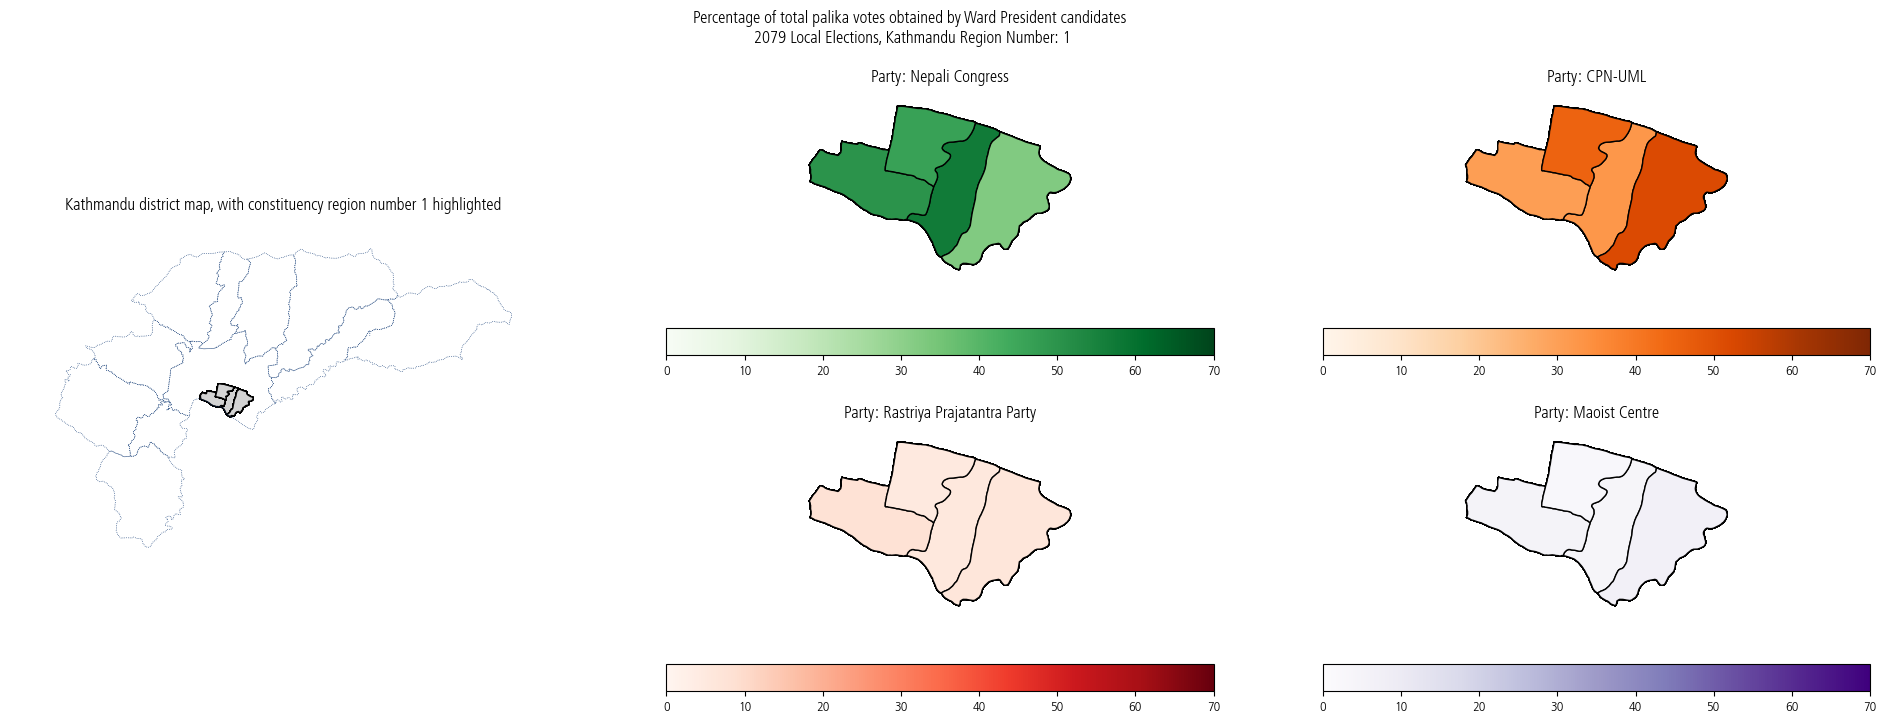

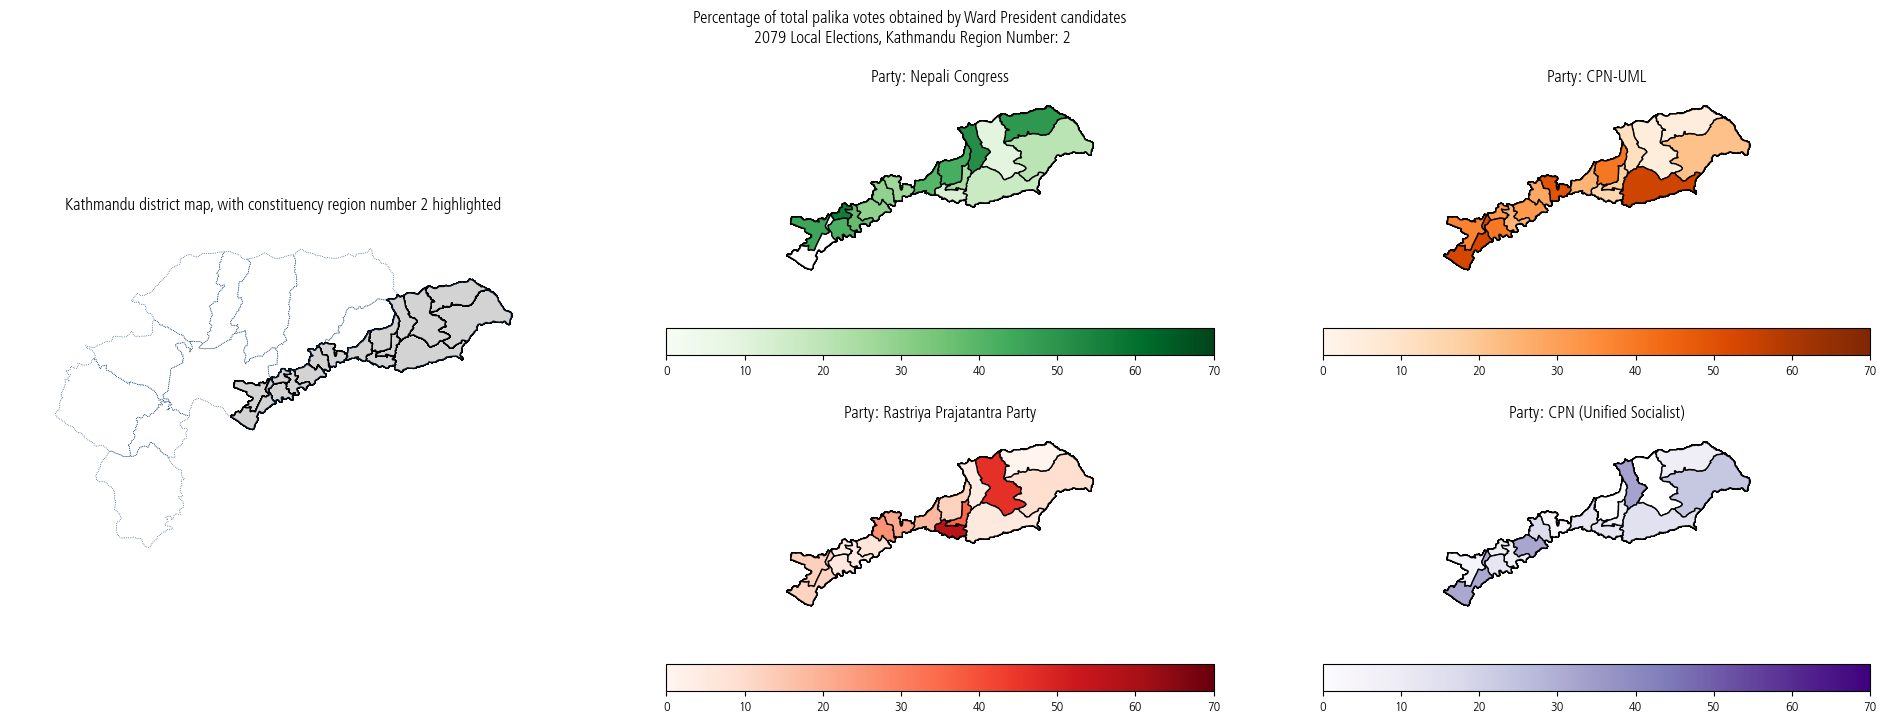

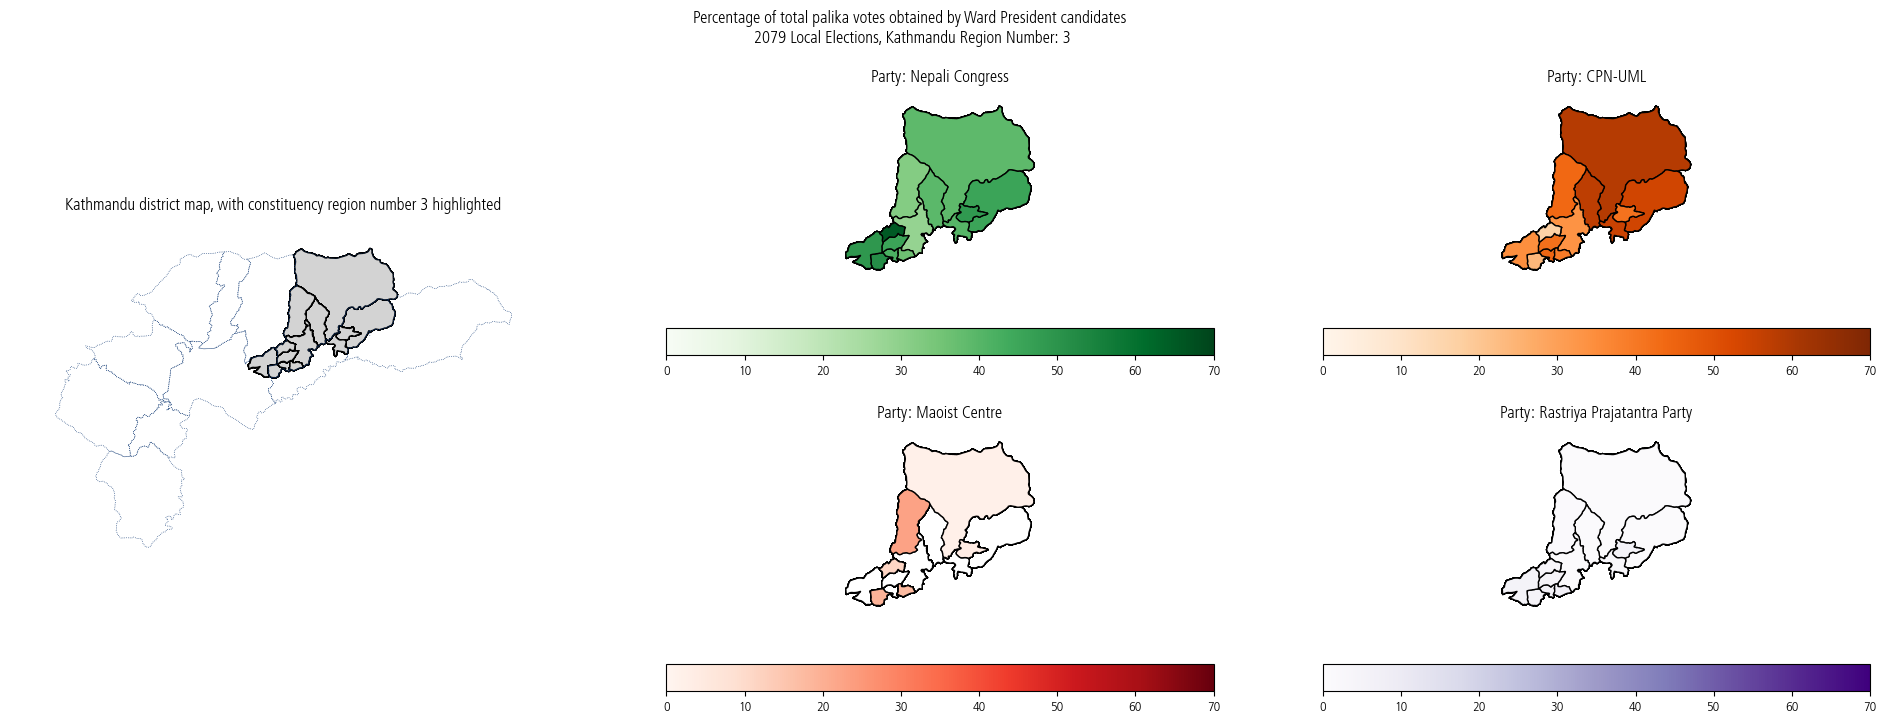

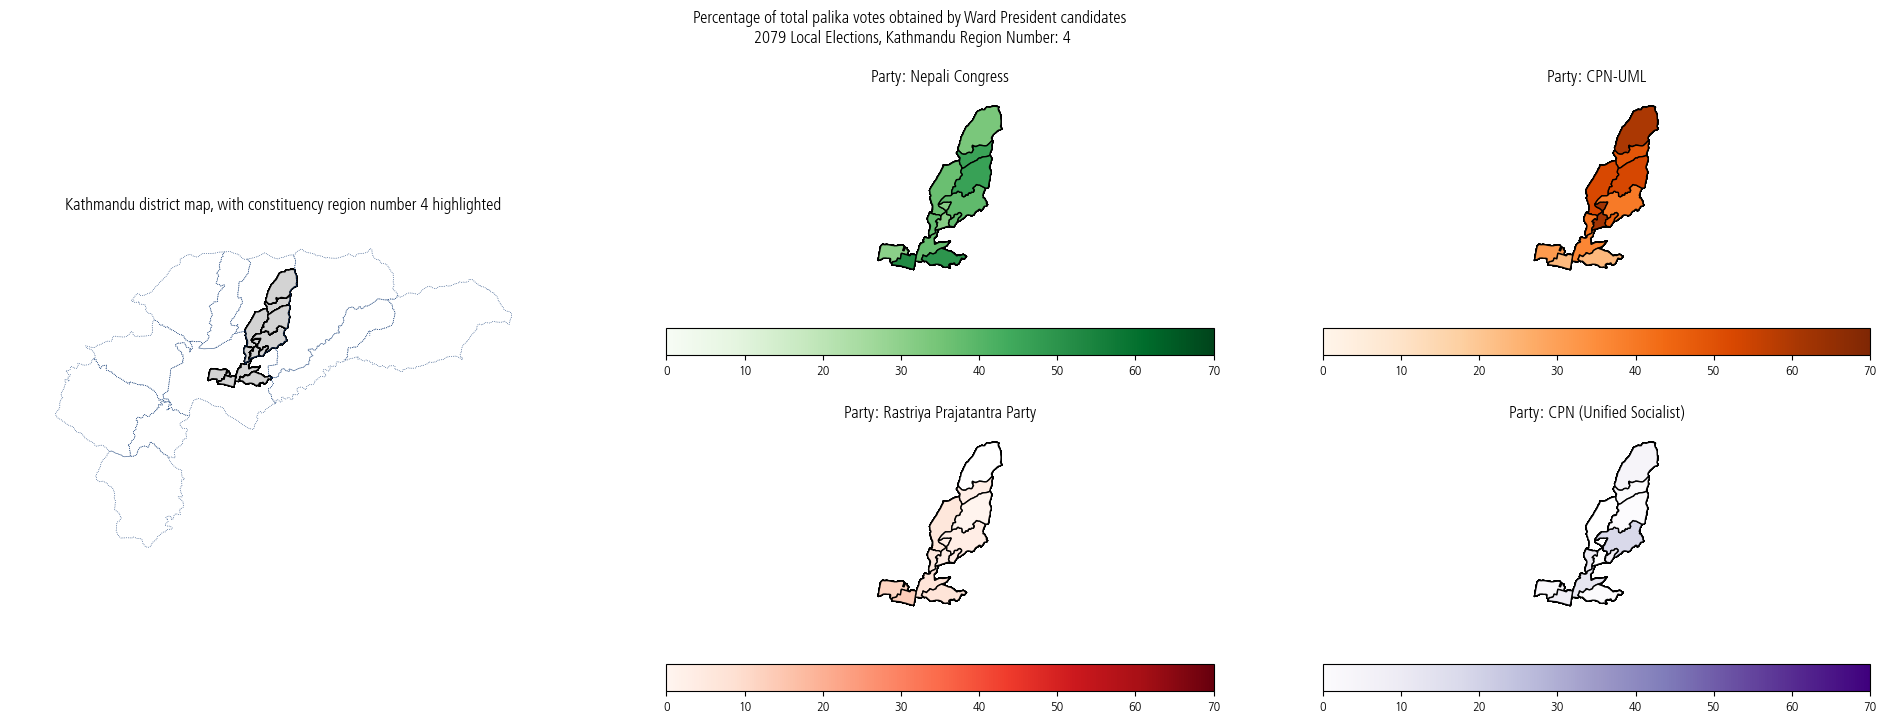

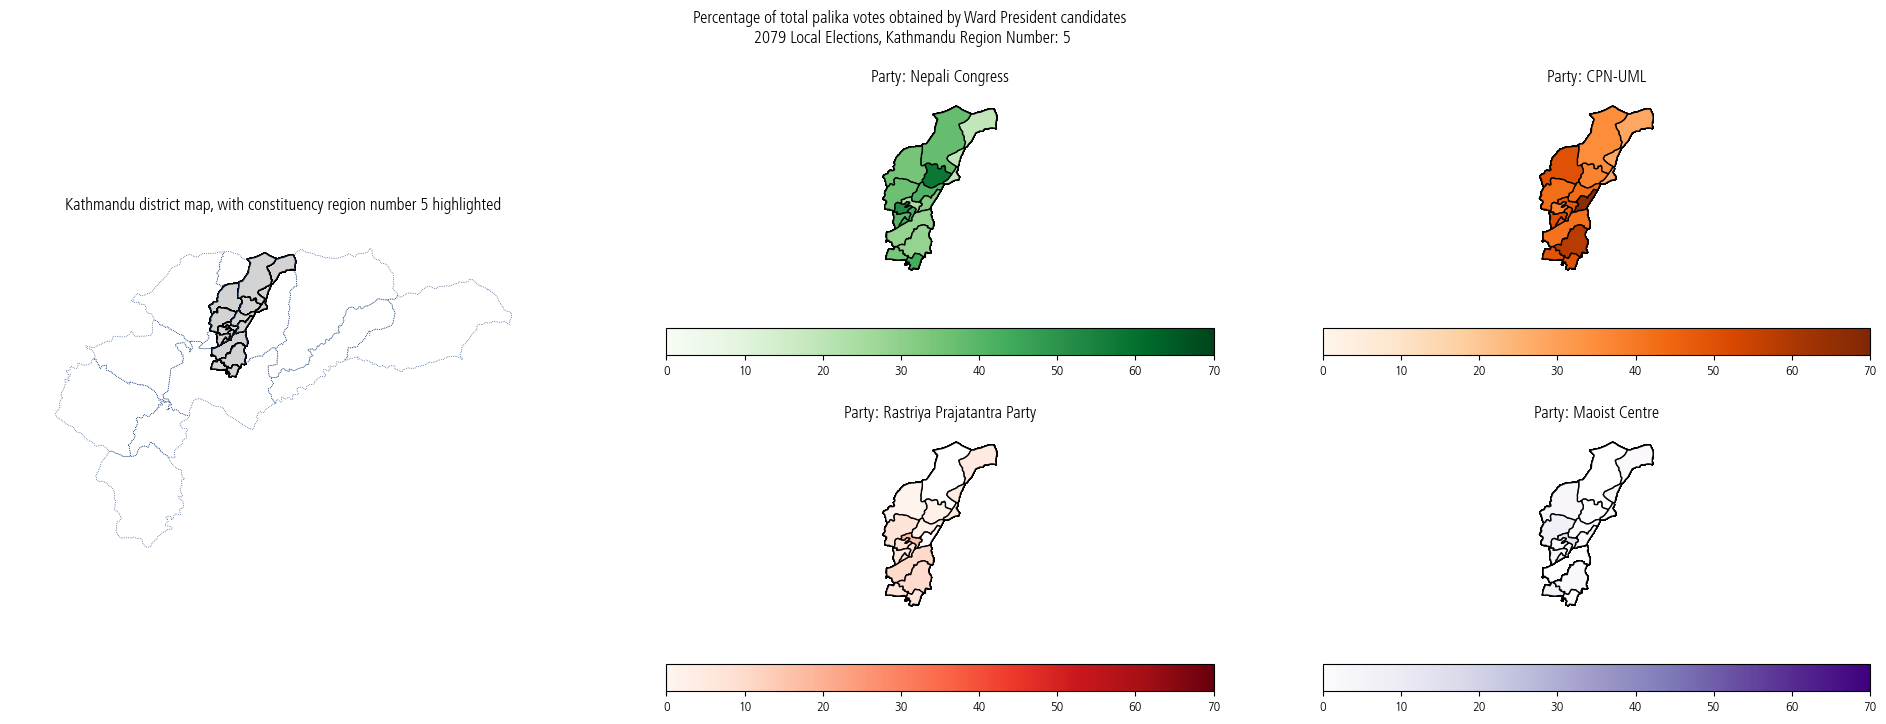

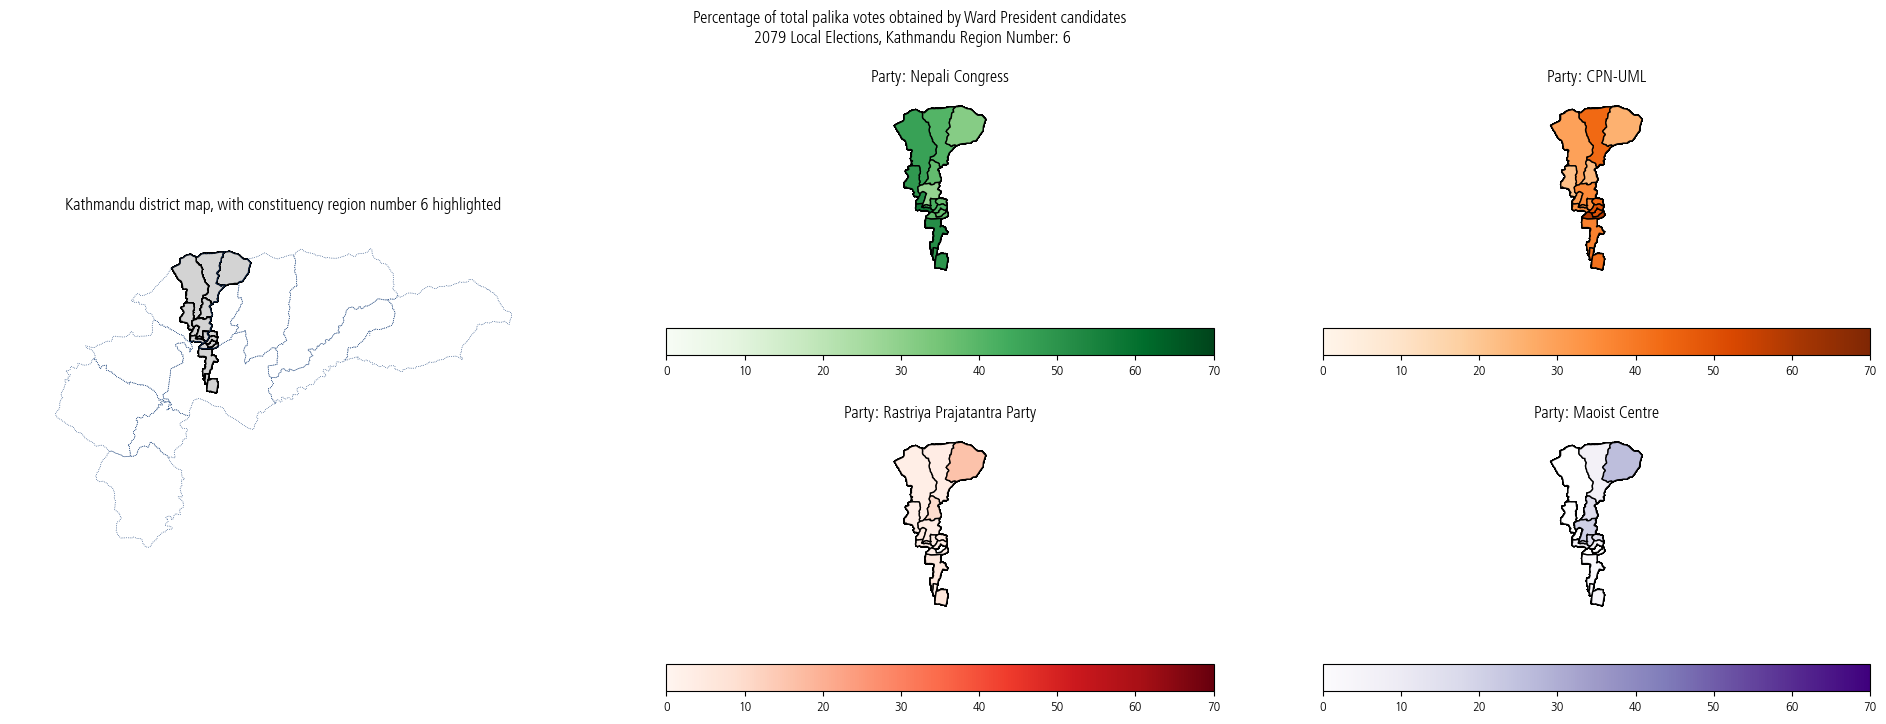

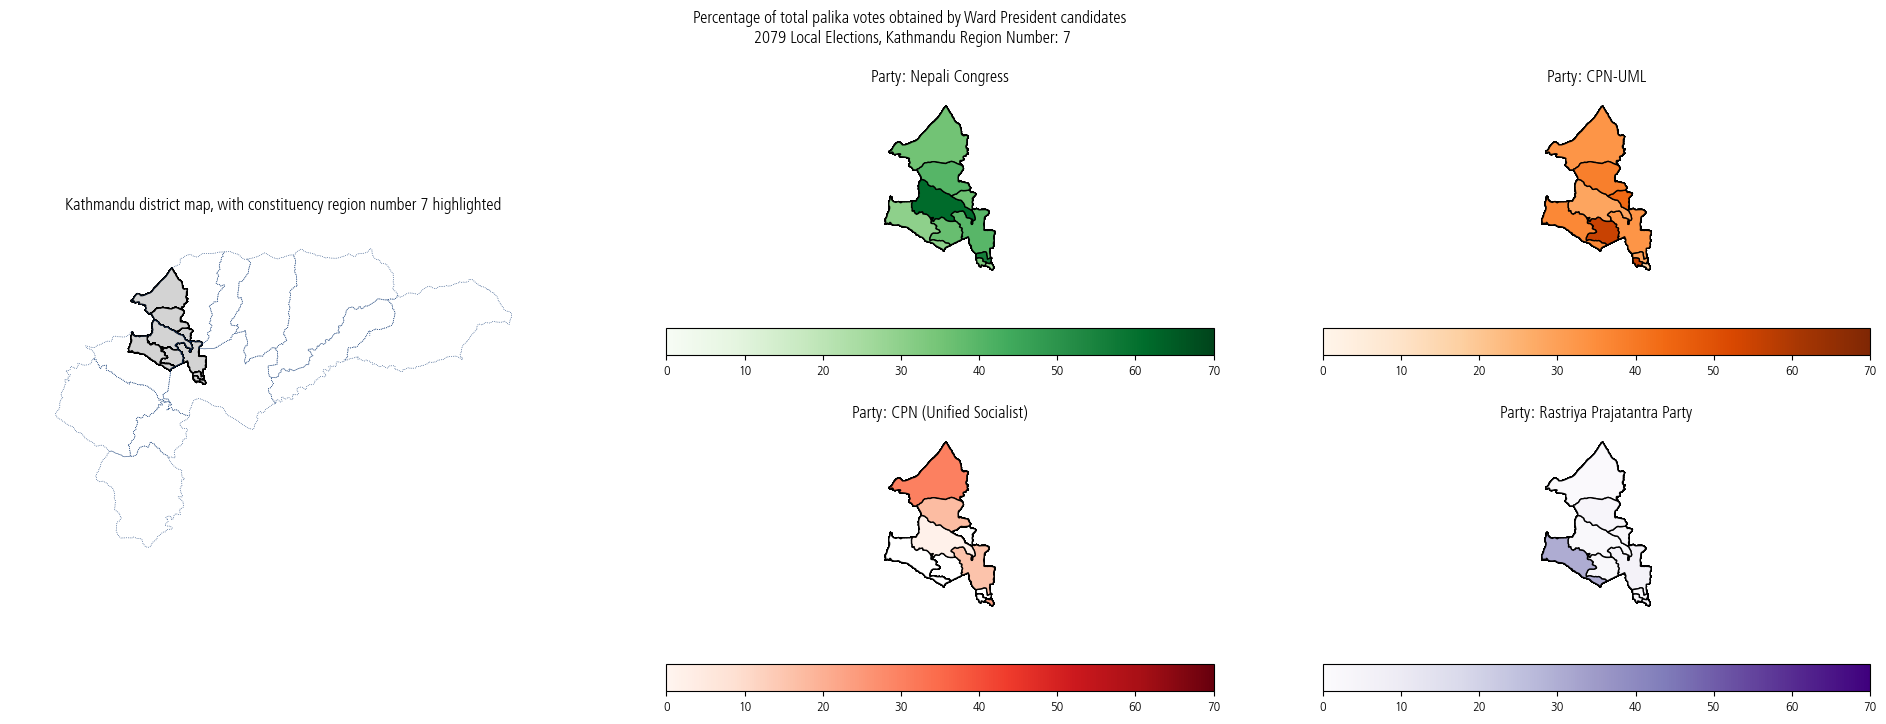

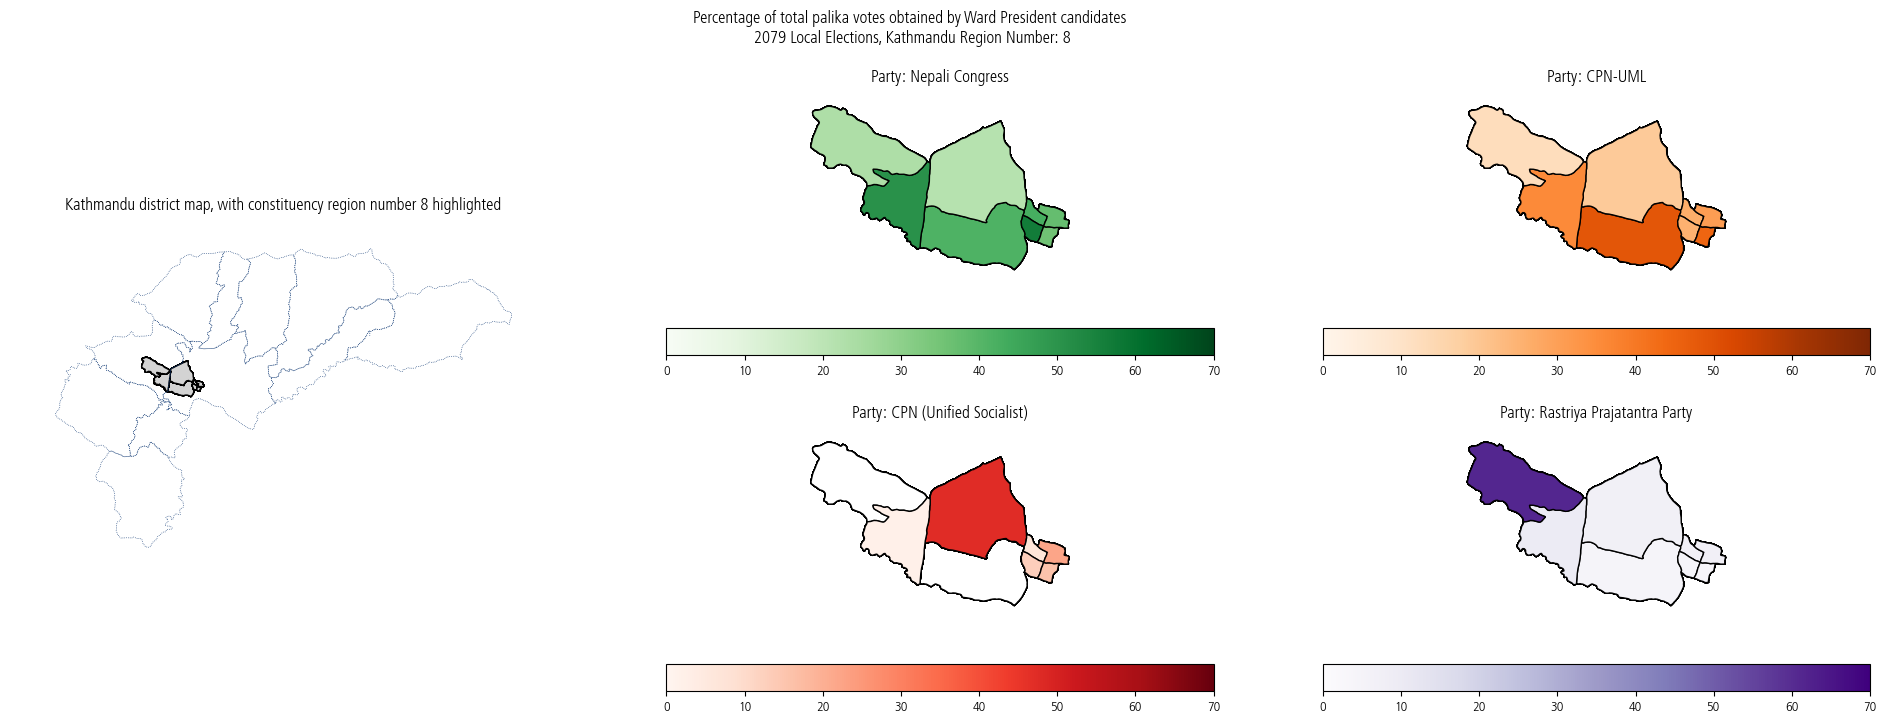

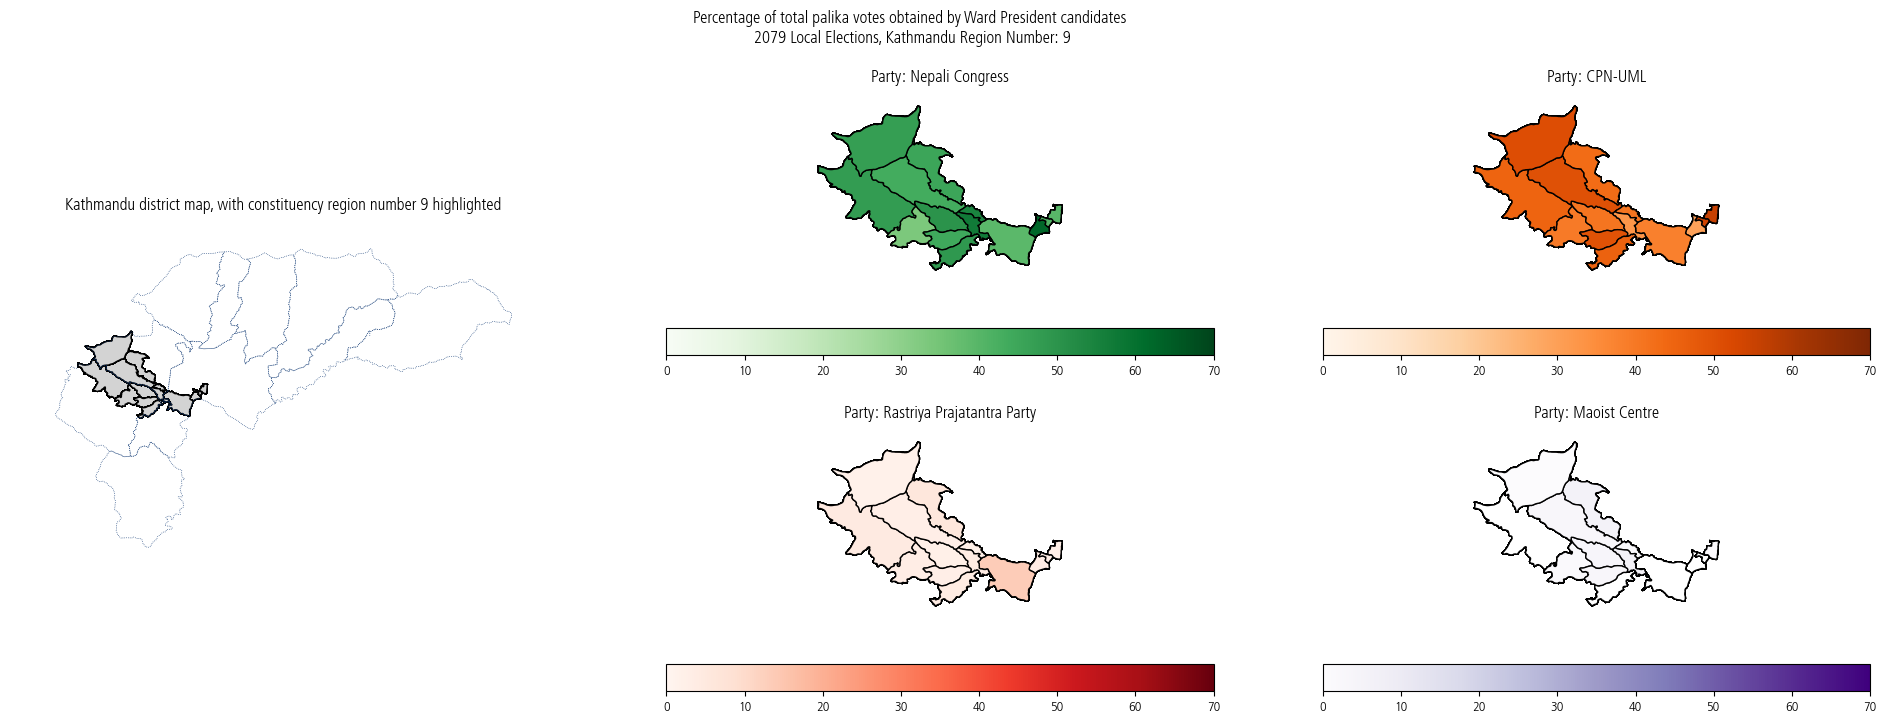

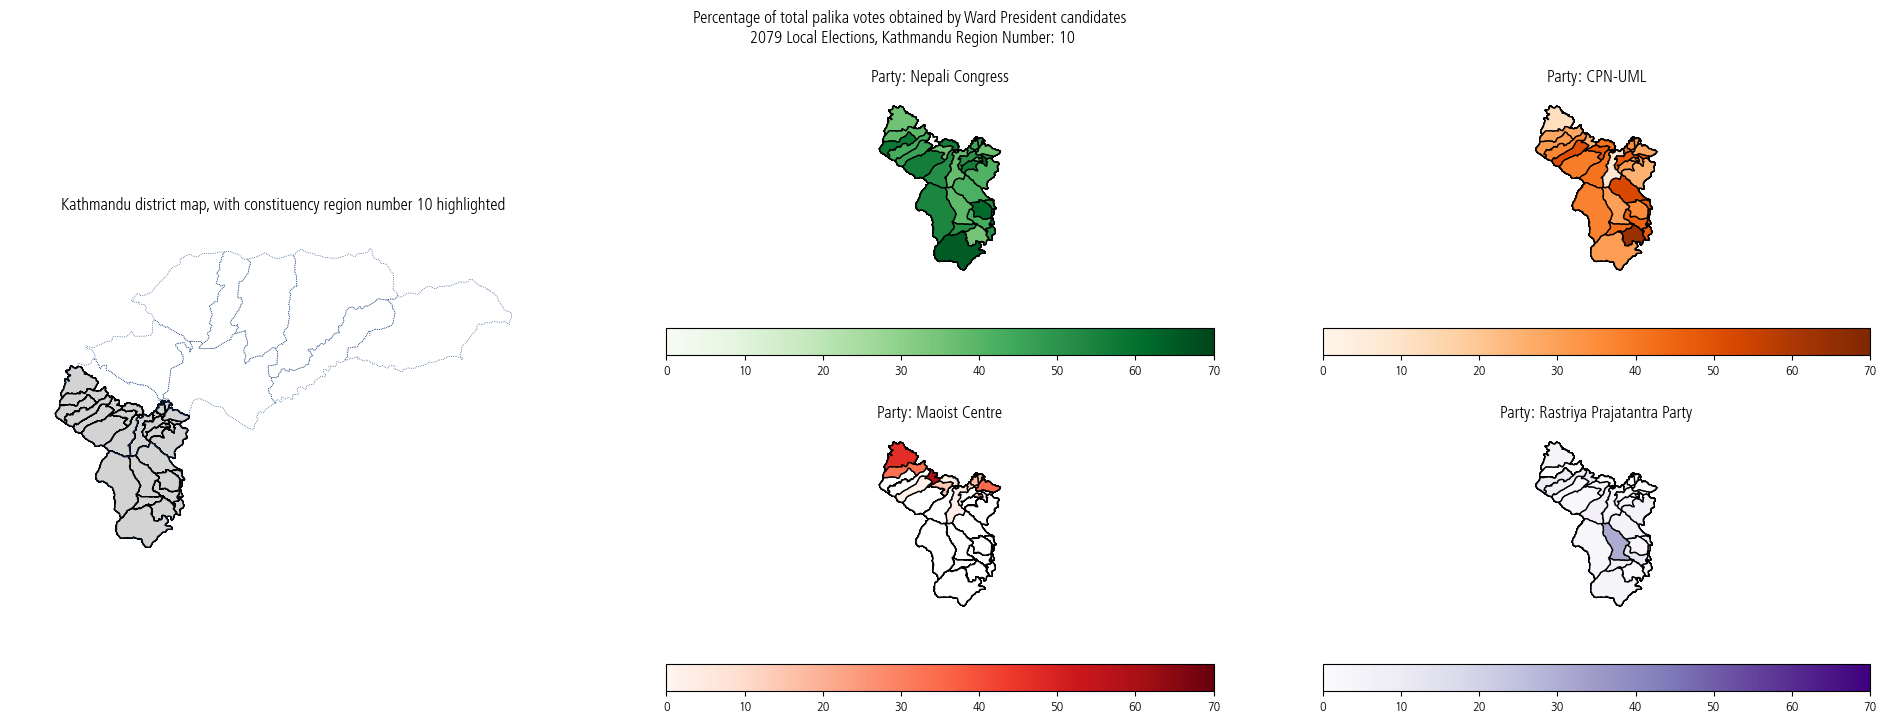

In [25]:
map_data_district = map_data.query(
    f'DISTRICT.str.contains("{district.upper()}")', engine="python"
)

regions = sorted(
    clean_elec_data_district["representative_constituency_r"].unique()
)  # the list of constituencies

for region in regions:
    regional_elec_data = clean_elec_data_district[
        clean_elec_data_district["representative_constituency_r"] == region
    ]

    fig, axes = prepare_axes((24, 8))

    skeleton_constituency_data_district = plot_district_with_constituency_highlight(
        axes[-1], regional_elec_data, map_data_district, district, region
    )

    # select the top 4 parties in that constituency
    top_parties_constituency = list(
        regional_elec_data.groupby(["party"])
        .sum("votes")
        .reset_index()
        .nlargest(4, ["votes"])
        .sort_values("votes", ascending=False)["party"]
    )

    if selected_party in list(top_parties_constituency):
        top_parties_constituency.remove(selected_party)
        alternatives = top_parties_constituency
    else:
        alternatives = top_parties_constituency[:3]
    selected_parties = [selected_party, *alternatives]

    # to use when all parties cmaps have been populated
    # selected_parties_cmap = {party:parties_map[k] for party in selected_parties if party in parties_map}

    # for the meantime when all cmaps have not been populated
    selected_parties_cmap = {}
    for idx, party in enumerate(selected_parties):
        selected_parties_cmap[party] = parties_colors[idx]

    for idx, (party, pallete) in enumerate(selected_parties_cmap.items()):
        final_data = gpd.GeoDataFrame(
            preprocess_data(regional_elec_data, post, party).merge(
                map_data_district,
                how="inner",
                left_on=["palika", "ward"],
                right_on=["PALIKA", "WARD"],
            )
        )

        cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=pallete).cmap

        gplt.choropleth(
            final_data,
            hue="% of ward votes",
            cmap=cmap,
            norm=norm,
            legend=True,
            legend_kwargs={"orientation": "horizontal"},
            ax=axes[idx],
        )

        # since 0 vote regions are omitted by the choropleth map, we draw a white backgrounded polygon map
        gplt.polyplot(
            skeleton_constituency_data_district,
            facecolor="white",
            ax=axes[idx],
        )
        axes[idx].set_title(f"Party: {party}")
    fig.suptitle(
        f"Percentage of total palika votes obtained by {post} candidates\n 2079 Local Elections, {district.capitalize()} Region Number: {region}"
    )
    plt.show()